In [106]:
import sys
!{sys.executable} -m pip install -U pip
!{sys.executable} -m pip install  japanize-matplotlib


10367.02s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


10372.91s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [115]:
import os
import numpy as np
import pandas as pd

HEAT_PATH = "heatstroke_r7.csv"
TEMP_PATH = "max_tmp_r7.csv"   # ←ここを実ファイル名に合わせる

def parse_date(series: pd.Series) -> pd.Series:
    s = series.astype(str).str.strip()
    # 「2025年5月1日」みたいな表記も吸収
    s = (s.str.replace("年", "/", regex=False)
           .str.replace("月", "/", regex=False)
           .str.replace("日", "",  regex=False))
    return pd.to_datetime(s, errors="coerce").dt.normalize()  # 時刻を00:00に

print("TEMP file exists:", os.path.exists(TEMP_PATH))
if os.path.exists(TEMP_PATH):
    print("TEMP file size:", os.path.getsize(TEMP_PATH), "bytes")

heat_df = pd.read_csv(HEAT_PATH, encoding="utf-8-sig")
temp_df = pd.read_csv(TEMP_PATH, encoding="utf-8-sig")

print("heat_df shape:", heat_df.shape)
print("temp_df shape:", temp_df.shape)
print("temp_df columns:", list(temp_df.columns))

# 列名を統一（TEMP側が「年月日,最高気温」想定）
temp_df = temp_df.rename(columns={"年月日": "日付", "最高気温": "最高気温_C"})

# 日付・数値化
heat_df["日付"] = parse_date(heat_df["日付"])
heat_df["搬送人員（計）"] = pd.to_numeric(heat_df["搬送人員（計）"], errors="coerce")

if "日付" not in temp_df.columns:
    raise KeyError(f"TEMP側に日付列がありません。columns={list(temp_df.columns)}")
if "最高気温_C" not in temp_df.columns:
    raise KeyError(f"TEMP側に最高気温列がありません。columns={list(temp_df.columns)}")

temp_df["日付"] = parse_date(temp_df["日付"])
temp_df["最高気温_C"] = pd.to_numeric(temp_df["最高気温_C"], errors="coerce")

# 欠損除去
heat_df = heat_df.dropna(subset=["日付", "搬送人員（計）"])
temp_df = temp_df.dropna(subset=["日付", "最高気温_C"])

# 日次集計
heat_day = heat_df.groupby("日付", as_index=False)["搬送人員（計）"].sum()

# 同一日付が複数ある場合に備えてTEMPも日次に（平均）
temp_day = (temp_df.groupby("日付", as_index=False)["最高気温_C"].mean())

# merge
df_max = (heat_day.merge(temp_day, on="日付", how="inner")
                  .sort_values("日付")
                  .reset_index(drop=True))


TEMP file exists: True
TEMP file size: 5261 bytes
heat_df shape: (153, 22)
temp_df shape: (153, 2)
temp_df columns: ['年月日', '最高気温']


In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# === 読み込み ===
heat = pd.read_csv("heatstroke_r7.csv", encoding="utf-8-sig")
temp = pd.read_csv("max_tmp_r7.csv", encoding="utf-8-sig")

# === 日付列を揃える ===
heat["日付"] = pd.to_datetime(heat["日付"], errors="coerce")
temp = temp.rename(columns={"年月日": "日付", "最高気温": "最高気温_C"})
temp["日付"] = pd.to_datetime(temp["日付"], errors="coerce")

# === 数値化 ===
heat["搬送人員（計）"] = pd.to_numeric(heat["搬送人員（計）"], errors="coerce")
temp["最高気温_C"] = pd.to_numeric(temp["最高気温_C"], errors="coerce")

# （必要なら）都道府県コードでフィルタ
# pref_code = 8
# heat = heat.loc[heat["都道府県コード"] == pref_code].copy()

# 同一日付が複数行あるなら日次合計にする
heat_day = heat.groupby("日付", as_index=False)["搬送人員（計）"].sum()

# === マージ ===
df = heat_day.merge(temp[["日付", "最高気温_C"]], on="日付", how="inner").dropna()



/tmp/ipykernel_9235/95748132.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temp["日付"] = pd.to_datetime(temp["日付"], errors="coerce")


In [109]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

# ===== データ取り出し（df_max を使う）=====
T = df_max["最高気温_C"].to_numpy(dtype=float)          # 当日最高気温
y = df_max["搬送人員（計）"].to_numpy(dtype=float)

mask = np.isfinite(T) & np.isfinite(y)
T, y = T[mask], y[mask]

# ========= 特徴量生成 =========
def make_X(T, threshold=False, degree=1, tau=None):
    if not threshold:
        return T.reshape(-1, 1) if degree == 1 else np.c_[T, T**2]
    if tau is None:
        raise ValueError("threshold=True のとき tau が必要です")
    z = np.maximum(0.0, T - tau)
    return z.reshape(-1, 1) if degree == 1 else np.c_[z, z**2]

# ========= CV-RMSE（時系列分割） =========
def cv_rmse_linearreg(X, y, n_splits=5):
    n = len(y)
    if n < n_splits + 2:
        return np.nan
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rmses = []
    for tr, te in tscv.split(X):
        model = LinearRegression().fit(X[tr], y[tr])
        pred = model.predict(X[te])
        rmses.append(np.sqrt(mean_squared_error(y[te], pred)))
    return float(np.mean(rmses))

# ========= 閾値 tau をグリッドサーチ =========
def find_best_tau(T, y, degree, n_grid=120, n_splits=5):
    lo, hi = np.percentile(T, [5, 95])
    taus = np.linspace(lo, hi, n_grid)
    best = None  # (cv_rmse, tau)
    for tau in taus:
        X = make_X(T, threshold=True, degree=degree, tau=tau)
        rmse = cv_rmse_linearreg(X, y, n_splits=n_splits)
        if np.isnan(rmse):
            continue
        if best is None or rmse < best[0]:
            best = (rmse, float(tau))
    return best

# ========= 4パターン推定 =========
rows = []

# 1) 閾値なし degree=1
X = make_X(T, threshold=False, degree=1)
m = LinearRegression().fit(X, y)
rows.append({
    "pattern": "閾値なし degree=1",
    "tau(℃)": np.nan,
    "degree": 1,
    "intercept": float(m.intercept_),
    "coef": m.coef_.tolist(),
    "RMSE_train": float(np.sqrt(mean_squared_error(y, m.predict(X)))),
    "R2_train": float(r2_score(y, m.predict(X))),
    "RMSE_CV": cv_rmse_linearreg(X, y),
})

# 2) 閾値なし degree=2
X = make_X(T, threshold=False, degree=2)
m = LinearRegression().fit(X, y)
rows.append({
    "pattern": "閾値なし degree=2",
    "tau(℃)": np.nan,
    "degree": 2,
    "intercept": float(m.intercept_),
    "coef": m.coef_.tolist(),
    "RMSE_train": float(np.sqrt(mean_squared_error(y, m.predict(X)))),
    "R2_train": float(r2_score(y, m.predict(X))),
    "RMSE_CV": cv_rmse_linearreg(X, y),
})

# 3) 閾値あり degree=1
best = find_best_tau(T, y, degree=1)
best_rmse, best_tau = best
X = make_X(T, threshold=True, degree=1, tau=best_tau)
m = LinearRegression().fit(X, y)
rows.append({
    "pattern": "閾値あり degree=1",
    "tau(℃)": best_tau,
    "degree": 1,
    "intercept": float(m.intercept_),
    "coef": m.coef_.tolist(),
    "RMSE_train": float(np.sqrt(mean_squared_error(y, m.predict(X)))),
    "R2_train": float(r2_score(y, m.predict(X))),
    "RMSE_CV": best_rmse,
})

# 4) 閾値あり degree=2
best = find_best_tau(T, y, degree=2)
best_rmse, best_tau = best
X = make_X(T, threshold=True, degree=2, tau=best_tau)
m = LinearRegression().fit(X, y)
rows.append({
    "pattern": "閾値あり degree=2",
    "tau(℃)": best_tau,
    "degree": 2,
    "intercept": float(m.intercept_),
    "coef": m.coef_.tolist(),
    "RMSE_train": float(np.sqrt(mean_squared_error(y, m.predict(X)))),
    "R2_train": float(r2_score(y, m.predict(X))),
    "RMSE_CV": best_rmse,
})

result = pd.DataFrame(rows).sort_values("RMSE_CV").reset_index(drop=True)
display(result)


,pattern,tau(℃),degree,intercept,coef,RMSE_train,R2_train,RMSE_CV
0,閾値あり degree=1,28.214310,1,1.113524,[5.189476197147113],8.733319,0.736936,9.521511
1,閾値あり degree=2,21.574106,2,1.694747,"[-1.6563047751630322, 0.3179934496106012]",8.518484,0.749720,9.755694
2,閾値なし degree=2,NaN,2,126.358513,"[-11.336992348001013, 0.25026325881141953]",8.705208,0.738627,10.002030
3,閾値なし degree=1,NaN,1,-58.565756,[2.533913719731578],11.036815,0.579864,12.744116


best tau = 21.57 ℃, CV-RMSE = 9.756
intercept_ = 1.6947472723639638
coef_      = [-1.65630478  0.31799345]


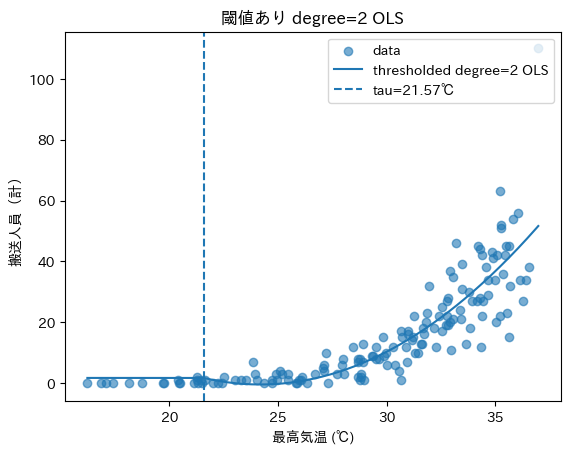

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# 日本語表示（入れてあるなら）
# import japanize_matplotlib

# ---- df から 温度(℃) と y を取り出す ----
if "最高気温_C" in df_max.columns:
    T = df_max["最高気温_C"].to_numpy(dtype=float)
elif "最高気温_K" in df_max.columns:
    T = (df_max["最高気温_K"].to_numpy(dtype=float) - 273.15)
else:
    raise KeyError("df に '最高気温_C' か '最高気温_K' が必要です")

y = df_max["搬送人員（計）"].to_numpy(dtype=float)

mask = np.isfinite(T) & np.isfinite(y)
T, y = T[mask], y[mask]

# ---- 特徴量: z=max(0, T-tau), [z, z^2] ----
def make_X(T, tau):
    z = np.maximum(0.0, T - tau)
    return np.c_[z, z**2]

def cv_rmse(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rmses = []
    for tr, te in tscv.split(X):
        m = LinearRegression().fit(X[tr], y[tr])
        pred = m.predict(X[te])
        rmses.append(np.sqrt(mean_squared_error(y[te], pred)))
    return float(np.mean(rmses))

# ---- tau をCVで探索（必要なら分割数/グリッド数を調整） ----
lo, hi = np.percentile(T, [5, 95])
taus = np.linspace(lo, hi, 120)

best_rmse, best_tau = None, None
for tau in taus:
    X = make_X(T, tau)
    rmse = cv_rmse(X, y, n_splits=5)
    if best_rmse is None or rmse < best_rmse:
        best_rmse, best_tau = rmse, float(tau)

print(f"best tau = {best_tau:.2f} ℃, CV-RMSE = {best_rmse:.3f}")

# ---- 最良 tau で学習 ----
X = make_X(T, best_tau)
model = LinearRegression().fit(X, y)
print("intercept_ =", model.intercept_)
print("coef_      =", model.coef_)  # [z, z^2]

# ---- 描画（散布図 + 回帰曲線） ----
tgrid = np.linspace(T.min(), T.max(), 400)
Xg = make_X(tgrid, best_tau)
yhat = model.predict(Xg)

plt.figure()
plt.scatter(T, y, alpha=0.6, label="data")
plt.plot(tgrid, yhat, label="thresholded degree=2 OLS")
plt.axvline(best_tau, linestyle="--", label=f"tau={best_tau:.2f}℃")

plt.xlabel("最高気温 (℃)")
plt.ylabel("搬送人員（計）")
plt.title("閾値あり degree=2 OLS")
plt.legend()
plt.show()


,pattern,tau,degree,intercept,coef,RMSE_train,R2_train,RMSE_CV
0,閾値なし degree=2,NaN,2,112.955238,"[-12.746038062685322, 0.35275011055249217]",9.702175,0.699622,11.502871
1,閾値あり degree=1,20.513914,1,-1.595416,[4.4456881034232945],10.458195,0.650985,11.938504
2,閾値あり degree=2,15.221429,2,4.162422,"[-3.0343655822105533, 0.41301321990695317]",9.549631,0.708993,12.024527
3,閾値なし degree=1,NaN,1,-54.641950,[2.9847334239636925],11.947556,0.544500,13.845356


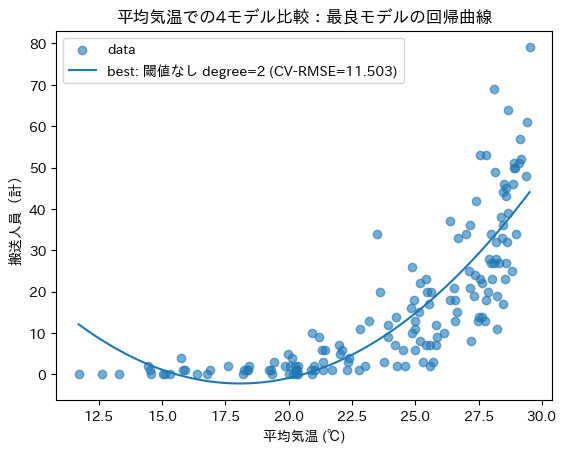

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

# 日本語が出ないなら（入れてある前提）
# import japanize_matplotlib

# ========= 読み込み =========
heat = pd.read_csv("heatstroke_r5.csv", encoding="utf-8-sig")
avg  = pd.read_csv("avg_tmp.csv", encoding="utf-8-sig")

# ========= 日付整形 =========
heat["日付"] = pd.to_datetime(heat["日付"], errors="coerce")
avg = avg.rename(columns={"年月日": "日付", "平均気温": "平均気温_C"})
avg["日付"] = pd.to_datetime(avg["日付"], errors="coerce")

# ========= 数値化 =========
heat["搬送人員（計）"] = pd.to_numeric(heat["搬送人員（計）"], errors="coerce")
avg["平均気温_C"] = pd.to_numeric(avg["平均気温_C"], errors="coerce")

# （必要なら）都道府県コードで絞る
# pref_code = 8
# heat = heat.loc[heat["都道府県コード"] == pref_code].copy()

# 同一日付が複数行なら日次合計
heat_day = heat.groupby("日付", as_index=False)["搬送人員（計）"].sum()

# ========= マージして時系列順に =========
df2 = (
    heat_day.merge(avg[["日付", "平均気温_C"]], on="日付", how="inner")
            .dropna()
            .sort_values("日付")
            .reset_index(drop=True)
)

T = df2["平均気温_C"].to_numpy(dtype=float)
y = df2["搬送人員（計）"].to_numpy(dtype=float)

# ========= 特徴量 =========
def make_X(T, threshold=False, degree=1, tau=None):
    if not threshold:
        if degree == 1:
            return T.reshape(-1, 1)
        elif degree == 2:
            return np.c_[T, T**2]
        else:
            raise ValueError("degree must be 1 or 2")
    else:
        if tau is None:
            raise ValueError("threshold=True のとき tau が必要です")
        z = np.maximum(0.0, T - tau)
        if degree == 1:
            return z.reshape(-1, 1)
        elif degree == 2:
            return np.c_[z, z**2]
        else:
            raise ValueError("degree must be 1 or 2")

def cv_rmse(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rmses = []
    for tr, te in tscv.split(X):
        m = LinearRegression().fit(X[tr], y[tr])
        pred = m.predict(X[te])
        rmses.append(np.sqrt(mean_squared_error(y[te], pred)))
    return float(np.mean(rmses))

def find_best_tau(T, y, degree, n_grid=120, n_splits=5):
    lo, hi = np.percentile(T, [5, 95])
    taus = np.linspace(lo, hi, n_grid)
    best = None  # (rmse, tau)
    for tau in taus:
        X = make_X(T, threshold=True, degree=degree, tau=tau)
        rmse = cv_rmse(X, y, n_splits=n_splits)
        if best is None or rmse < best[0]:
            best = (rmse, float(tau))
    return best

# ========= 4モデル推定 =========
rows = []

# 1) 閾値なし degree=1
X = make_X(T, threshold=False, degree=1)
m = LinearRegression().fit(X, y)
rows.append(dict(pattern="閾値なし degree=1", tau=None, degree=1,
                 intercept=float(m.intercept_), coef=m.coef_.tolist(),
                 RMSE_train=float(np.sqrt(mean_squared_error(y, m.predict(X)))),
                 R2_train=float(r2_score(y, m.predict(X))),
                 RMSE_CV=cv_rmse(X, y)))

# 2) 閾値なし degree=2
X = make_X(T, threshold=False, degree=2)
m = LinearRegression().fit(X, y)
rows.append(dict(pattern="閾値なし degree=2", tau=None, degree=2,
                 intercept=float(m.intercept_), coef=m.coef_.tolist(),
                 RMSE_train=float(np.sqrt(mean_squared_error(y, m.predict(X)))),
                 R2_train=float(r2_score(y, m.predict(X))),
                 RMSE_CV=cv_rmse(X, y)))

# 3) 閾値あり degree=1（tauも推定）
best_rmse, best_tau = find_best_tau(T, y, degree=1)
X = make_X(T, threshold=True, degree=1, tau=best_tau)
m = LinearRegression().fit(X, y)
rows.append(dict(pattern="閾値あり degree=1", tau=best_tau, degree=1,
                 intercept=float(m.intercept_), coef=m.coef_.tolist(),
                 RMSE_train=float(np.sqrt(mean_squared_error(y, m.predict(X)))),
                 R2_train=float(r2_score(y, m.predict(X))),
                 RMSE_CV=best_rmse))

# 4) 閾値あり degree=2（tauも推定）
best_rmse, best_tau = find_best_tau(T, y, degree=2)
X = make_X(T, threshold=True, degree=2, tau=best_tau)
m = LinearRegression().fit(X, y)
rows.append(dict(pattern="閾値あり degree=2", tau=best_tau, degree=2,
                 intercept=float(m.intercept_), coef=m.coef_.tolist(),
                 RMSE_train=float(np.sqrt(mean_squared_error(y, m.predict(X)))),
                 R2_train=float(r2_score(y, m.predict(X))),
                 RMSE_CV=best_rmse))

res = pd.DataFrame(rows).sort_values("RMSE_CV").reset_index(drop=True)
display(res)

# ========= 最良（CV-RMSE最小）モデルをプロット =========
best = res.loc[0].to_dict()
best_pattern = best["pattern"]
best_tau = best["tau"]
best_degree = int(best["degree"])

# 最良モデルで全データfit
X_best = make_X(T, threshold=("閾値あり" in best_pattern), degree=best_degree, tau=best_tau)
model_best = LinearRegression().fit(X_best, y)

# 曲線
tgrid = np.linspace(T.min(), T.max(), 400)
Xg = make_X(tgrid, threshold=("閾値あり" in best_pattern), degree=best_degree, tau=best_tau)
yhat = model_best.predict(Xg)

plt.figure()
plt.scatter(T, y, alpha=0.6, label="data")
plt.plot(tgrid, yhat, label=f"best: {best_pattern} (CV-RMSE={best['RMSE_CV']:.3f})")

if "閾値あり" in best_pattern:
    plt.axvline(best_tau, linestyle="--", label=f"tau={best_tau:.2f}℃")

plt.xlabel("平均気温 (℃)")
plt.ylabel("搬送人員（計）")
plt.title("平均気温での4モデル比較：最良モデルの回帰曲線")
plt.legend()
plt.show()


,pattern,tau,degree,intercept,coef,RMSE_train,R2_train,RMSE_CV
0,閾値あり degree=1,13.801681,1,-2.103046,[2.908337551576091],13.391585,0.427739,15.959893
1,閾値なし degree=1,NaN,1,-27.474745,[2.2343055525399103],13.932328,0.380591,16.138470
2,閾値あり degree=2,18.981345,2,2.975077,"[5.774450259539775, -0.08768946480786148]",12.686723,0.486395,16.459625
3,閾値なし degree=2,NaN,2,33.532173,"[-5.461442678609783, 0.21942265654500714]",12.903841,0.468665,16.764694


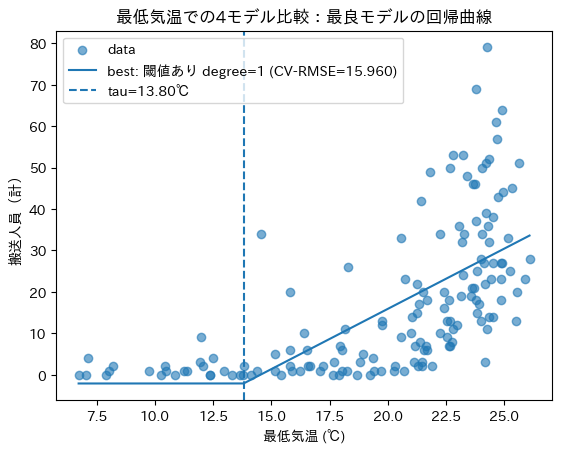

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

# 日本語が出ないなら（入れてある前提）
# import japanize_matplotlib

# ========= 読み込み =========
heat = pd.read_csv("heatstroke_r5.csv", encoding="utf-8-sig")
mn   = pd.read_csv("min_tmp.csv", encoding="utf-8-sig")

# ========= 日付整形 =========
heat["日付"] = pd.to_datetime(heat["日付"], errors="coerce")
mn = mn.rename(columns={"年月日": "日付", "最低気温": "最低気温_C"})
mn["日付"] = pd.to_datetime(mn["日付"], errors="coerce")

# ========= 数値化 =========
heat["搬送人員（計）"] = pd.to_numeric(heat["搬送人員（計）"], errors="coerce")
mn["最低気温_C"] = pd.to_numeric(mn["最低気温_C"], errors="coerce")

# （必要なら）都道府県コードで絞る
# pref_code = 8
# heat = heat.loc[heat["都道府県コード"] == pref_code].copy()

# 同一日付が複数行なら日次合計
heat_day = heat.groupby("日付", as_index=False)["搬送人員（計）"].sum()

# ========= マージして時系列順に =========
df3 = (
    heat_day.merge(mn[["日付", "最低気温_C"]], on="日付", how="inner")
            .dropna()
            .sort_values("日付")
            .reset_index(drop=True)
)

T = df3["最低気温_C"].to_numpy(dtype=float)
y = df3["搬送人員（計）"].to_numpy(dtype=float)

# ========= 特徴量 =========
def make_X(T, threshold=False, degree=1, tau=None):
    if not threshold:
        if degree == 1:
            return T.reshape(-1, 1)
        elif degree == 2:
            return np.c_[T, T**2]
        else:
            raise ValueError("degree must be 1 or 2")
    else:
        if tau is None:
            raise ValueError("threshold=True のとき tau が必要です")
        z = np.maximum(0.0, T - tau)
        if degree == 1:
            return z.reshape(-1, 1)
        elif degree == 2:
            return np.c_[z, z**2]
        else:
            raise ValueError("degree must be 1 or 2")

def cv_rmse(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rmses = []
    for tr, te in tscv.split(X):
        m = LinearRegression().fit(X[tr], y[tr])
        pred = m.predict(X[te])
        rmses.append(np.sqrt(mean_squared_error(y[te], pred)))
    return float(np.mean(rmses))

def find_best_tau(T, y, degree, n_grid=120, n_splits=5):
    lo, hi = np.percentile(T, [5, 95])
    taus = np.linspace(lo, hi, n_grid)
    best = None  # (rmse, tau)
    for tau in taus:
        X = make_X(T, threshold=True, degree=degree, tau=tau)
        rmse = cv_rmse(X, y, n_splits=n_splits)
        if best is None or rmse < best[0]:
            best = (rmse, float(tau))
    return best

# ========= 4モデル推定 =========
rows = []

# 1) 閾値なし degree=1
X = make_X(T, threshold=False, degree=1)
m = LinearRegression().fit(X, y)
rows.append(dict(pattern="閾値なし degree=1", tau=None, degree=1,
                 intercept=float(m.intercept_), coef=m.coef_.tolist(),
                 RMSE_train=float(np.sqrt(mean_squared_error(y, m.predict(X)))),
                 R2_train=float(r2_score(y, m.predict(X))),
                 RMSE_CV=cv_rmse(X, y)))

# 2) 閾値なし degree=2
X = make_X(T, threshold=False, degree=2)
m = LinearRegression().fit(X, y)
rows.append(dict(pattern="閾値なし degree=2", tau=None, degree=2,
                 intercept=float(m.intercept_), coef=m.coef_.tolist(),
                 RMSE_train=float(np.sqrt(mean_squared_error(y, m.predict(X)))),
                 R2_train=float(r2_score(y, m.predict(X))),
                 RMSE_CV=cv_rmse(X, y)))

# 3) 閾値あり degree=1（tauも推定）
best_rmse, best_tau = find_best_tau(T, y, degree=1)
X = make_X(T, threshold=True, degree=1, tau=best_tau)
m = LinearRegression().fit(X, y)
rows.append(dict(pattern="閾値あり degree=1", tau=best_tau, degree=1,
                 intercept=float(m.intercept_), coef=m.coef_.tolist(),
                 RMSE_train=float(np.sqrt(mean_squared_error(y, m.predict(X)))),
                 R2_train=float(r2_score(y, m.predict(X))),
                 RMSE_CV=best_rmse))

# 4) 閾値あり degree=2（tauも推定）
best_rmse, best_tau = find_best_tau(T, y, degree=2)
X = make_X(T, threshold=True, degree=2, tau=best_tau)
m = LinearRegression().fit(X, y)
rows.append(dict(pattern="閾値あり degree=2", tau=best_tau, degree=2,
                 intercept=float(m.intercept_), coef=m.coef_.tolist(),
                 RMSE_train=float(np.sqrt(mean_squared_error(y, m.predict(X)))),
                 R2_train=float(r2_score(y, m.predict(X))),
                 RMSE_CV=best_rmse))

res = pd.DataFrame(rows).sort_values("RMSE_CV").reset_index(drop=True)
display(res)

# ========= 最良モデルをプロット =========
best = res.loc[0].to_dict()
best_pattern = best["pattern"]
best_tau = best["tau"]
best_degree = int(best["degree"])

X_best = make_X(T, threshold=("閾値あり" in best_pattern), degree=best_degree, tau=best_tau)
model_best = LinearRegression().fit(X_best, y)

tgrid = np.linspace(T.min(), T.max(), 400)
Xg = make_X(tgrid, threshold=("閾値あり" in best_pattern), degree=best_degree, tau=best_tau)
yhat = model_best.predict(Xg)

plt.figure()
plt.scatter(T, y, alpha=0.6, label="data")
plt.plot(tgrid, yhat, label=f"best: {best_pattern} (CV-RMSE={best['RMSE_CV']:.3f})")

if "閾値あり" in best_pattern:
    plt.axvline(best_tau, linestyle="--", label=f"tau={best_tau:.2f}℃")

plt.xlabel("最低気温 (℃)")
plt.ylabel("搬送人員（計）")
plt.title("最低気温での4モデル比較：最良モデルの回帰曲線")
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

# =========================
# 0) 入力ファイル
# =========================
HEAT_PATH = "heatstroke_r7.csv"
WBGT_PATH = "wgbt.csv"

# （必要なら）都道府県コードで絞る
# PREF_CODE = 8
PREF_CODE = None

# =========================
# 1) 熱中症搬送（日次）を作る
# =========================
heat = pd.read_csv(HEAT_PATH, encoding="utf-8-sig")
heat["日付"] = pd.to_datetime(heat["日付"], errors="coerce")
heat["搬送人員（計）"] = pd.to_numeric(heat["搬送人員（計）"], errors="coerce")

if PREF_CODE is not None:
    heat = heat.loc[heat["都道府県コード"] == PREF_CODE].copy()

# 同一日付が複数行（都道府県など）なら合計
heat_day = (
    heat.groupby("日付", as_index=False)["搬送人員（計）"]
        .sum()
        .dropna()
        .sort_values("日付")
        .reset_index(drop=True)
)

# =========================
# 2) WBGT（時刻別）→ 日次特徴量（3種類 × WBGT/Tg）
# =========================
wb = pd.read_csv(WBGT_PATH)

# Date, Time を datetime に
wb["datetime"] = pd.to_datetime(wb["Date"].astype(str) + " " + wb["Time"].astype(str), errors="coerce")
wb["日付"] = wb["datetime"].dt.normalize()  # 00:00にそろえる

wb["WBGT"] = pd.to_numeric(wb["WBGT"], errors="coerce")
wb["Tg"]   = pd.to_numeric(wb["Tg"],   errors="coerce")

wb = wb.dropna(subset=["日付"]).sort_values(["日付", "datetime"]).reset_index(drop=True)

def around_max_mean(g: pd.DataFrame, col: str) -> float:
    """その日の col の最大値が出た時刻の前後1時間(=3点)の平均。端は存在する分だけで平均。"""
    x = g[col].to_numpy(dtype=float)
    if np.all(~np.isfinite(x)):
        return np.nan
    # nanを無視して最大の位置を取る
    idx = int(np.nanargmax(x))
    idxs = [i for i in (idx - 1, idx, idx + 1) if 0 <= i < len(x)]
    return float(np.nanmean(x[idxs]))

daily = (
    wb.groupby("日付", as_index=False)
      .apply(lambda g: pd.Series({
          # WBGTの3種類
          "WBGT_mean": float(np.nanmean(g["WBGT"].to_numpy(dtype=float))),
          "WBGT_max":  float(np.nanmax(g["WBGT"].to_numpy(dtype=float))),
          "WBGT_max3h": around_max_mean(g, "WBGT"),
          # Tgの3種類（Tgとして別々に回帰する）
          "Tg_mean": float(np.nanmean(g["Tg"].to_numpy(dtype=float))),
          "Tg_max":  float(np.nanmax(g["Tg"].to_numpy(dtype=float))),
          "Tg_max3h": around_max_mean(g, "Tg"),
      }))
      .reset_index()
)

# ↑ groupby.apply の都合で列名が変になる環境があるので保険
if "日付" not in daily.columns:
    daily = daily.rename(columns={"level_0": "日付"})

daily = daily.sort_values("日付").reset_index(drop=True)

# =========================
# 3) マージして回帰用データ
# =========================
df = (
    heat_day.merge(daily, on="日付", how="inner")
            .dropna(subset=["搬送人員（計）"])  # y
            .sort_values("日付")
            .reset_index(drop=True)
)

# =========================
# 4) 6回の線形回帰（OLS: LinearRegression）
#    3種類（mean / max / max±1h平均） × 2種（WBGT / Tg）
# =========================
feature_cols = [
    ("WBGT", "WBGT_mean"),
    ("WBGT", "WBGT_max"),
    ("WBGT", "WBGT_max3h"),
    ("Tg",   "Tg_mean"),
    ("Tg",   "Tg_max"),
    ("Tg",   "Tg_max3h"),
]

def cv_rmse_time_series(X, y, n_splits=5) -> float:
    """時系列分割でのCV RMSE（未来をテストに回す）"""
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rmses = []
    for tr, te in tscv.split(X):
        m = LinearRegression().fit(X[tr], y[tr])
        pred = m.predict(X[te])
        rmses.append(np.sqrt(mean_squared_error(y[te], pred)))
    return float(np.mean(rmses))

y = df["搬送人員（計）"].to_numpy(dtype=float)

results = []
for group_name, col in feature_cols:
    tmp = df[["日付", col, "搬送人員（計）"]].dropna().copy()
    X = tmp[[col]].to_numpy(dtype=float)
    yy = tmp["搬送人員（計）"].to_numpy(dtype=float)

    model = LinearRegression().fit(X, yy)
    pred = model.predict(X)

    rmse_train = float(np.sqrt(mean_squared_error(yy, pred)))
    r2_train = float(r2_score(yy, pred))
    rmse_cv = cv_rmse_time_series(X, yy, n_splits=5) if len(tmp) >= 20 else np.nan  # データ少ないと不安定なので保険

    results.append({
        "type": group_name,
        "feature": col,
        "n": int(len(tmp)),
        "intercept": float(model.intercept_),
        "coef": float(model.coef_[0]),
        "RMSE_train": rmse_train,
        "R2_train": r2_train,
        "RMSE_CV": rmse_cv,
    })

res = pd.DataFrame(results).sort_values(["type", "feature"]).reset_index(drop=True)
display(res)


/tmp/ipykernel_9235/802320737.py:63: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,type,feature,n,intercept,coef,RMSE_train,R2_train,RMSE_CV
0,Tg,Tg_max,153,-43.636858,1.448061,12.523684,0.459038,14.805451
1,Tg,Tg_max3h,153,-43.046948,1.523118,12.026253,0.501158,14.225149
2,Tg,Tg_mean,153,-53.476156,2.468774,10.578897,0.614004,12.287387
3,WBGT,WBGT_max,153,-58.686373,2.772091,11.231096,0.564943,12.841371
4,WBGT,WBGT_max3h,153,-56.861348,2.771818,11.112126,0.574111,12.682372
5,WBGT,WBGT_mean,153,-49.810219,2.848870,11.631908,0.533336,13.058260


intercept_ = -53.47615581881207
coef_      = 2.468773570951251


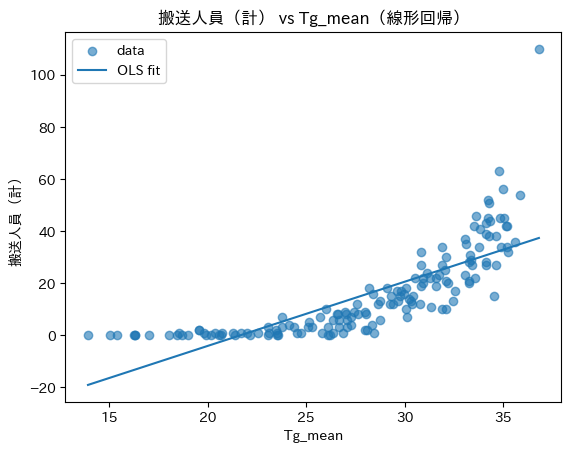

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# 日本語が出ないなら（入れてある前提）
# import japanize_matplotlib

# df は前のセルで作った（heat_day と daily を merge した）ものを想定
tmp = df[["日付", "Tg_mean", "搬送人員（計）"]].dropna().sort_values("日付").copy()

X = tmp[["Tg_mean"]].to_numpy(dtype=float)
y = tmp["搬送人員（計）"].to_numpy(dtype=float)

model = LinearRegression().fit(X, y)

print("intercept_ =", model.intercept_)
print("coef_      =", model.coef_[0])

# --- 回帰直線用 ---
xgrid = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
yhat = model.predict(xgrid)

plt.figure()
plt.scatter(X[:, 0], y, alpha=0.6, label="data")
plt.plot(xgrid[:, 0], yhat, label="OLS fit")
plt.xlabel("Tg_mean")
plt.ylabel("搬送人員（計）")
plt.title("搬送人員（計） vs Tg_mean（線形回帰）")
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

# ========= dfの列名を正規化（前後の空白を除去） =========
df2 = df.rename(columns=lambda c: c.strip() if isinstance(c, str) else c)

# ========= Tg_mean列を見つける（無ければTgmean_0を使う） =========
tg_col = None
for cand in ["Tg_mean", "Tgmean_0"]:
    if cand in df2.columns:
        tg_col = cand
        break

if tg_col is None:
    raise KeyError(f"Tg列が見つかりません。df.columns={list(df2.columns)}")

# ========= データ準備 =========
tmp = (
    df2[["日付", tg_col, "搬送人員（計）"]]
    .dropna()
    .sort_values("日付")
    .rename(columns={tg_col: "Tg_mean"})  # 以降の処理を統一
    .reset_index(drop=True)
)

T = tmp["Tg_mean"].to_numpy(dtype=float)
y = tmp["搬送人員（計）"].to_numpy(dtype=float)

# ========= 特徴量 =========
def make_X(T, threshold=False, degree=1, tau=None):
    if not threshold:
        return T.reshape(-1, 1) if degree == 1 else np.c_[T, T**2]
    else:
        if tau is None:
            raise ValueError("threshold=True のとき tau が必要です")
        z = np.maximum(0.0, T - tau)
        return z.reshape(-1, 1) if degree == 1 else np.c_[z, z**2]

def cv_rmse(X, y, n_splits=5):
    if len(y) < (n_splits + 1):
        return np.nan
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rmses = []
    for tr, te in tscv.split(X):
        m = LinearRegression().fit(X[tr], y[tr])
        pred = m.predict(X[te])
        rmses.append(np.sqrt(mean_squared_error(y[te], pred)))
    return float(np.mean(rmses))

def find_best_tau(T, y, degree, n_grid=120, n_splits=5):
    lo, hi = np.percentile(T, [5, 95])
    taus = np.linspace(lo, hi, n_grid)

    best = None  # (rmse, tau)
    for tau in taus:
        X = make_X(T, threshold=True, degree=degree, tau=tau)
        rmse = cv_rmse(X, y, n_splits=n_splits)
        if np.isnan(rmse):
            continue
        if best is None or rmse < best[0]:
            best = (rmse, float(tau))
    return best  # (best_rmse, best_tau) or None

# ========= 4回の回帰 =========
rows = []

# 1) 閾値なし degree=1
X = make_X(T, threshold=False, degree=1)
m = LinearRegression().fit(X, y)
rows.append({
    "pattern": "閾値なし degree=1",
    "tau": None,
    "coef": m.coef_.tolist(),
    "intercept": float(m.intercept_),
    "RMSE(train)": float(np.sqrt(mean_squared_error(y, m.predict(X)))),
    "R2(train)": float(r2_score(y, m.predict(X))),
    "RMSE(CV)": cv_rmse(X, y),
})

# 2) 閾値なし degree=2
X = make_X(T, threshold=False, degree=2)
m = LinearRegression().fit(X, y)
rows.append({
    "pattern": "閾値なし degree=2",
    "tau": None,
    "coef": m.coef_.tolist(),  # [T, T^2]
    "intercept": float(m.intercept_),
    "RMSE(train)": float(np.sqrt(mean_squared_error(y, m.predict(X)))),
    "R2(train)": float(r2_score(y, m.predict(X))),
    "RMSE(CV)": cv_rmse(X, y),
})

# 3) 閾値あり degree=1（tau推定）
best = find_best_tau(T, y, degree=1)
if best is not None:
    best_rmse, best_tau = best
    X = make_X(T, threshold=True, degree=1, tau=best_tau)
    m = LinearRegression().fit(X, y)
    rows.append({
        "pattern": "閾値あり degree=1",
        "tau": best_tau,
        "coef": m.coef_.tolist(),  # [z]
        "intercept": float(m.intercept_),
        "RMSE(train)": float(np.sqrt(mean_squared_error(y, m.predict(X)))),
        "R2(train)": float(r2_score(y, m.predict(X))),
        "RMSE(CV)": best_rmse,
    })
else:
    rows.append({"pattern": "閾値あり degree=1", "tau": None, "coef": None, "intercept": None,
                 "RMSE(train)": None, "R2(train)": None, "RMSE(CV)": None})

# 4) 閾値あり degree=2（tau推定）
best = find_best_tau(T, y, degree=2)
if best is not None:
    best_rmse, best_tau = best
    X = make_X(T, threshold=True, degree=2, tau=best_tau)
    m = LinearRegression().fit(X, y)
    rows.append({
        "pattern": "閾値あり degree=2",
        "tau": best_tau,
        "coef": m.coef_.tolist(),  # [z, z^2]
        "intercept": float(m.intercept_),
        "RMSE(train)": float(np.sqrt(mean_squared_error(y, m.predict(X)))),
        "R2(train)": float(r2_score(y, m.predict(X))),
        "RMSE(CV)": best_rmse,
    })
else:
    rows.append({"pattern": "閾値あり degree=2", "tau": None, "coef": None, "intercept": None,
                 "RMSE(train)": None, "R2(train)": None, "RMSE(CV)": None})

res = pd.DataFrame(rows).sort_values("RMSE(CV)")
display(res)


,pattern,tau,coef,intercept,RMSE(train),R2(train),RMSE(CV)
3,閾値あり degree=2,20.802850,"[-1.4520559302947609, 0.31134554399044934]",1.740615,7.449614,0.808588,8.122800
2,閾値あり degree=1,27.417537,[5.273182167473022],2.033838,7.930245,0.783092,8.352748
1,閾値なし degree=2,NaN,"[-9.771700250366262, 0.23129856542515315]",101.069714,7.727671,0.794032,8.634466
0,閾値なし degree=1,NaN,[2.468773570951251],-53.476156,10.578897,0.614004,12.287387


In [ ]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

YCOL = "搬送人員（計）"
DATECOL = "日付"

# まず列名の前後空白を除去（"WBGT_mean " みたいな事故対策）
df2 = df.rename(columns=lambda c: c.strip() if isinstance(c, str) else c)

# --- 候補列名のリスト（あなたの作り方の揺れを吸収） ---
CANDIDATES = {
    "WBGT_mean":  ["WBGT_mean", "WBGT_mean_", "WBGT mean", "WBGT_mean_daily", "WBGT平均", "WBGT_daily_mean"],
    "WBGT_max":   ["WBGT_max", "WBGT_max_", "WBGT max", "WBGT最大", "WBGT_daily_max"],
    "WBGT_max3h": ["WBGT_max3h", "WBGT_max3h_", "WBGT_max3", "WBGT_around_max", "WBGT前後1h平均", "WBGT_max_around"],
    "Tg_mean":    ["Tg_mean", "Tg_mean_", "Tg mean", "Tgmean_0", "Tg_mean0", "Tg平均", "Tg_daily_mean"],
    "Tg_max":     ["Tg_max", "Tg_max_", "Tg max", "Tg最大", "Tg_daily_max"],
    "Tg_max3h":   ["Tg_max3h", "Tg_max3h_", "Tg_max3", "Tg_around_max", "Tg前後1h平均", "Tg_max_around"],
}

def pick_existing(name):
    for cand in CANDIDATES[name]:
        if cand in df2.columns:
            return cand
    return None

feature_map = {k: pick_existing(k) for k in CANDIDATES.keys()}
missing = [k for k,v in feature_map.items() if v is None]

print("=== feature_map (logical -> actual) ===")
for k,v in feature_map.items():
    print(f"{k:10s} -> {v}")

if missing:
    # 何が足りないか分かるように列名一覧も出す
    raise KeyError(f"dfに必要な列がありません: {missing}\n現在のdf.columns={list(df2.columns)}")

FEATURES = [
    ("WBGT", feature_map["WBGT_mean"]),
    ("WBGT", feature_map["WBGT_max"]),
    ("WBGT", feature_map["WBGT_max3h"]),
    ("Tg",   feature_map["Tg_mean"]),
    ("Tg",   feature_map["Tg_max"]),
    ("Tg",   feature_map["Tg_max3h"]),
]

def make_X(x, threshold=False, degree=1, tau=None):
    x = np.asarray(x, dtype=float)
    if not threshold:
        return x.reshape(-1, 1) if degree == 1 else np.c_[x, x**2]
    if tau is None:
        raise ValueError("threshold=True のとき tau が必要です")
    z = np.maximum(0.0, x - tau)
    return z.reshape(-1, 1) if degree == 1 else np.c_[z, z**2]

def cv_rmse(X, y, max_splits=5):
    n = len(y)
    if n < 8:
        return np.nan
    n_splits = min(max_splits, n - 1)
    if n_splits < 2:
        return np.nan
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rmses = []
    for tr, te in tscv.split(X):
        m = LinearRegression().fit(X[tr], y[tr])
        pred = m.predict(X[te])
        rmses.append(np.sqrt(mean_squared_error(y[te], pred)))
    return float(np.mean(rmses))

def find_best_tau(x, y, degree, n_grid=120, max_splits=5):
    lo, hi = np.percentile(x, [5, 95])
    taus = np.linspace(lo, hi, n_grid)
    best = None  # (rmse, tau)
    for tau in taus:
        X = make_X(x, threshold=True, degree=degree, tau=tau)
        rmse = cv_rmse(X, y, max_splits=max_splits)
        if np.isnan(rmse):
            continue
        if best is None or rmse < best[0]:
            best = (rmse, float(tau))
    return best

def fit_4_models_for_feature(df_base, group_name, feat_col):
    tmp = (
        df_base[[DATECOL, feat_col, YCOL]]
        .dropna()
        .sort_values(DATECOL)
        .reset_index(drop=True)
    )
    x = tmp[feat_col].to_numpy(dtype=float)
    y = tmp[YCOL].to_numpy(dtype=float)

    rows = []

    # (1) thresholdなし degree=1
    X = make_X(x, threshold=False, degree=1)
    m = LinearRegression().fit(X, y)
    pred = m.predict(X)
    rows.append(dict(
        type=group_name, feature=feat_col, logical_feature=None,
        threshold=False, degree=1, tau=np.nan, n=len(y),
        intercept=float(m.intercept_),
        coef1=float(m.coef_[0]), coef2=np.nan,
        RMSE_train=float(np.sqrt(mean_squared_error(y, pred))),
        R2_train=float(r2_score(y, pred)),
        RMSE_CV=cv_rmse(X, y)
    ))

    # (2) thresholdなし degree=2
    X = make_X(x, threshold=False, degree=2)
    m = LinearRegression().fit(X, y)
    pred = m.predict(X)
    rows.append(dict(
        type=group_name, feature=feat_col, logical_feature=None,
        threshold=False, degree=2, tau=np.nan, n=len(y),
        intercept=float(m.intercept_),
        coef1=float(m.coef_[0]), coef2=float(m.coef_[1]),
        RMSE_train=float(np.sqrt(mean_squared_error(y, pred))),
        R2_train=float(r2_score(y, pred)),
        RMSE_CV=cv_rmse(X, y)
    ))

    # (3) thresholdあり degree=1
    best = find_best_tau(x, y, degree=1)
    if best is not None:
        best_rmse, tau = best
        X = make_X(x, threshold=True, degree=1, tau=tau)
        m = LinearRegression().fit(X, y)
        pred = m.predict(X)
        rows.append(dict(
            type=group_name, feature=feat_col, logical_feature=None,
            threshold=True, degree=1, tau=tau, n=len(y),
            intercept=float(m.intercept_),
            coef1=float(m.coef_[0]), coef2=np.nan,
            RMSE_train=float(np.sqrt(mean_squared_error(y, pred))),
            R2_train=float(r2_score(y, pred)),
            RMSE_CV=best_rmse
        ))
    else:
        rows.append(dict(type=group_name, feature=feat_col, logical_feature=None,
                         threshold=True, degree=1, tau=np.nan, n=len(y),
                         intercept=np.nan, coef1=np.nan, coef2=np.nan,
                         RMSE_train=np.nan, R2_train=np.nan, RMSE_CV=np.nan))

    # (4) thresholdあり degree=2
    best = find_best_tau(x, y, degree=2)
    if best is not None:
        best_rmse, tau = best
        X = make_X(x, threshold=True, degree=2, tau=tau)
        m = LinearRegression().fit(X, y)
        pred = m.predict(X)
        rows.append(dict(
            type=group_name, feature=feat_col, logical_feature=None,
            threshold=True, degree=2, tau=tau, n=len(y),
            intercept=float(m.intercept_),
            coef1=float(m.coef_[0]), coef2=float(m.coef_[1]),
            RMSE_train=float(np.sqrt(mean_squared_error(y, pred))),
            R2_train=float(r2_score(y, pred)),
            RMSE_CV=best_rmse
        ))
    else:
        rows.append(dict(type=group_name, feature=feat_col, logical_feature=None,
                         threshold=True, degree=2, tau=np.nan, n=len(y),
                         intercept=np.nan, coef1=np.nan, coef2=np.nan,
                         RMSE_train=np.nan, R2_train=np.nan, RMSE_CV=np.nan))
    return rows

# ====== 実行（24本）======
rows_all = []
for gname, fcol in FEATURES:
    rows_all.extend(fit_4_models_for_feature(df2, gname, fcol))

res24 = pd.DataFrame(rows_all).sort_values(["RMSE_CV", "type", "feature", "threshold", "degree"]).reset_index(drop=True)
display(res24)

best_each = res24.sort_values("RMSE_CV").groupby(["type", "feature"], as_index=False).first()
display(best_each)


=== feature_map (logical -> actual) ===
WBGT_mean  -> WBGT_mean
WBGT_max   -> WBGT_max
WBGT_max3h -> WBGT_max3h
Tg_mean    -> Tg_mean
Tg_max     -> Tg_max
Tg_max3h   -> Tg_max3h


,type,feature,logical_feature,threshold,degree,tau,n,intercept,coef1,coef2,RMSE_train,R2_train,RMSE_CV
0,Tg,Tg_mean,None,True,2,20.802850,153,1.740615,-1.452056,0.311346,7.449614,0.808588,8.122800
1,Tg,Tg_mean,None,True,1,27.417537,153,2.033838,5.273182,NaN,7.930245,0.783092,8.352748
2,Tg,Tg_mean,None,False,2,NaN,153,101.069714,-9.771700,0.231299,7.727671,0.794032,8.634466
3,WBGT,WBGT_max3h,None,True,1,25.031429,153,0.391618,5.703388,NaN,8.692345,0.739399,9.905179
4,WBGT,WBGT_max3h,None,True,2,18.692381,153,2.278510,-2.293636,0.399249,8.448814,0.753797,9.952347
5,WBGT,WBGT_mean,None,True,2,18.855864,153,2.500676,-3.022986,0.810705,8.324785,0.760972,9.958661
6,WBGT,WBGT_max,None,True,2,21.223697,153,1.742733,-1.741471,0.473121,8.577204,0.746257,10.033607
7,WBGT,WBGT_max3h,None,False,2,NaN,153,132.594490,-13.200217,0.323313,8.656083,0.741569,10.074092
8,WBGT,WBGT_max,None,True,1,25.239160,153,-0.138599,5.335918,NaN,9.056031,0.717136,10.175860
9,WBGT,WBGT_mean,None,False,2,NaN,153,148.502143,-16.561017,0.452493,8.933283,0.724752,10.252285


,type,feature,logical_feature,threshold,degree,tau,n,intercept,coef1,coef2,RMSE_train,R2_train,RMSE_CV
0,Tg,Tg_max,None,True,1,41.968067,153,4.506062,4.184521,0.186785,10.438212,0.624202,11.726295
1,Tg,Tg_max3h,None,True,2,37.177143,153,3.903783,1.523267,0.163216,9.831966,0.666587,11.328799
2,Tg,Tg_mean,None,True,2,20.802850,153,1.740615,-1.452056,0.311346,7.449614,0.808588,8.122800
3,WBGT,WBGT_max,None,True,2,21.223697,153,1.742733,-1.741471,0.473121,8.577204,0.746257,10.033607
4,WBGT,WBGT_max3h,None,True,1,25.031429,153,0.391618,5.703388,0.399249,8.692345,0.739399,9.905179
5,WBGT,WBGT_mean,None,True,2,18.855864,153,2.500676,-3.022986,0.810705,8.324785,0.760972,9.958661


In [ ]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

HEAT_PATH = "heatstroke_r5.csv"   # 必要なら変更
TEMP_PATH = "max_tmp.csv"        # 年月日,最高気温

PREF_CODE = None  # 例: 8（都道府県コードで絞る）。不要なら None。

# =========================
# 1) 熱中症搬送（日次y）
# =========================
heat = pd.read_csv(HEAT_PATH, encoding="utf-8-sig")
heat["日付"] = pd.to_datetime(heat["日付"], errors="coerce")
heat["搬送人員（計）"] = pd.to_numeric(heat["搬送人員（計）"], errors="coerce")

if PREF_CODE is not None:
    heat = heat.loc[heat["都道府県コード"] == PREF_CODE].copy()

heat_day = (
    heat.groupby("日付", as_index=False)["搬送人員（計）"]
        .sum()
        .dropna()
        .sort_values("日付")
        .reset_index(drop=True)
)

# =========================
# 2) 最高気温（日次）→ ラグ0/1/2
# =========================
temp = pd.read_csv(TEMP_PATH, encoding="utf-8-sig")
temp = temp.rename(columns={"年月日": "日付", "最高気温": "最高気温_C"})
temp["日付"] = pd.to_datetime(temp["日付"], errors="coerce")
temp["最高気温_C"] = pd.to_numeric(temp["最高気温_C"], errors="coerce")

temp_day = (
    temp.dropna(subset=["日付", "最高気温_C"])
        .groupby("日付", as_index=True)["最高気温_C"]
        .mean()          # 同日複数なら平均（必要ならmaxに変えてOK）
        .sort_index()
        .asfreq("D")     # 暦日ベースのラグにする
)

df_temp = pd.DataFrame({
    "日付": temp_day.index,
    "Tmax_0": temp_day.values,
    "Tmax_1": temp_day.shift(1).values,
    "Tmax_2": temp_day.shift(2).values,
})

# =========================
# 3) マージ（欠損除去）
# =========================
df = (
    heat_day.merge(df_temp, on="日付", how="inner")
            .dropna(subset=["搬送人員（計）", "Tmax_0", "Tmax_1", "Tmax_2"])
            .sort_values("日付")
            .reset_index(drop=True)
)

y = df["搬送人員（計）"].to_numpy(dtype=float)
x0 = df["Tmax_0"].to_numpy(dtype=float)
x1 = df["Tmax_1"].to_numpy(dtype=float)
x2 = df["Tmax_2"].to_numpy(dtype=float)

# =========================
# 4) 特徴量（閾値・次数）
# =========================
def make_X(x0, x1, x2, threshold=False, degree=1, tau=None):
    if not threshold:
        if degree == 1:
            return np.c_[x0, x1, x2]
        elif degree == 2:
            return np.c_[x0, x1, x2, x0**2, x1**2, x2**2]
        else:
            raise ValueError("degree must be 1 or 2")
    else:
        if tau is None:
            raise ValueError("threshold=True のとき tau が必要です")
        z0 = np.maximum(0.0, x0 - tau)
        z1 = np.maximum(0.0, x1 - tau)
        z2 = np.maximum(0.0, x2 - tau)
        if degree == 1:
            return np.c_[z0, z1, z2]
        elif degree == 2:
            return np.c_[z0, z1, z2, z0**2, z1**2, z2**2]
        else:
            raise ValueError("degree must be 1 or 2")

def cv_rmse(X, y, max_splits=5):
    n = len(y)
    if n < 8:
        return np.nan
    n_splits = min(max_splits, n - 1)
    if n_splits < 2:
        return np.nan
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rmses = []
    for tr, te in tscv.split(X):
        m = LinearRegression().fit(X[tr], y[tr])
        pred = m.predict(X[te])
        rmses.append(np.sqrt(mean_squared_error(y[te], pred)))
    return float(np.mean(rmses))

def find_best_tau(x0, x1, x2, y, degree, n_grid=120):
    # tauは当日気温（x0）の分布から探索（安定化のため端を避ける）
    lo, hi = np.percentile(x0, [5, 95])
    taus = np.linspace(lo, hi, n_grid)

    best = None  # (rmse, tau)
    for tau in taus:
        X = make_X(x0, x1, x2, threshold=True, degree=degree, tau=tau)
        rmse = cv_rmse(X, y)
        if np.isnan(rmse):
            continue
        if best is None or rmse < best[0]:
            best = (rmse, float(tau))
    return best  # None or (best_rmse, best_tau)

# =========================
# 5) 4モデルを推定して結果表示
# =========================
rows = []

# (1) 閾値なし degree=1
X = make_X(x0, x1, x2, threshold=False, degree=1)
m = LinearRegression().fit(X, y)
pred = m.predict(X)
rows.append({
    "pattern": "閾値なし degree=1",
    "tau(℃)": np.nan,
    "n": len(y),
    "RMSE(train)": float(np.sqrt(mean_squared_error(y, pred))),
    "R2(train)": float(r2_score(y, pred)),
    "RMSE(CV)": cv_rmse(X, y),
    "intercept": float(m.intercept_),
    "coef": m.coef_.tolist(),  # [Tmax_0, Tmax_1, Tmax_2]
})

# (2) 閾値なし degree=2
X = make_X(x0, x1, x2, threshold=False, degree=2)
m = LinearRegression().fit(X, y)
pred = m.predict(X)
rows.append({
    "pattern": "閾値なし degree=2",
    "tau(℃)": np.nan,
    "n": len(y),
    "RMSE(train)": float(np.sqrt(mean_squared_error(y, pred))),
    "R2(train)": float(r2_score(y, pred)),
    "RMSE(CV)": cv_rmse(X, y),
    "intercept": float(m.intercept_),
    "coef": m.coef_.tolist(),  # [T0,T1,T2,T0^2,T1^2,T2^2]
})

# (3) 閾値あり degree=1（tau推定）
best = find_best_tau(x0, x1, x2, y, degree=1)
if best is not None:
    best_rmse, tau = best
    X = make_X(x0, x1, x2, threshold=True, degree=1, tau=tau)
    m = LinearRegression().fit(X, y)
    pred = m.predict(X)
    rows.append({
        "pattern": "閾値あり degree=1",
        "tau(℃)": tau,
        "n": len(y),
        "RMSE(train)": float(np.sqrt(mean_squared_error(y, pred))),
        "R2(train)": float(r2_score(y, pred)),
        "RMSE(CV)": best_rmse,
        "intercept": float(m.intercept_),
        "coef": m.coef_.tolist(),  # [z0,z1,z2]
    })
else:
    rows.append({"pattern":"閾値あり degree=1","tau(℃)":np.nan,"n":len(y),
                 "RMSE(train)":np.nan,"R2(train)":np.nan,"RMSE(CV)":np.nan,"intercept":np.nan,"coef":np.nan})

# (4) 閾値あり degree=2（tau推定）
best = find_best_tau(x0, x1, x2, y, degree=2)
if best is not None:
    best_rmse, tau = best
    X = make_X(x0, x1, x2, threshold=True, degree=2, tau=tau)
    m = LinearRegression().fit(X, y)
    pred = m.predict(X)
    rows.append({
        "pattern": "閾値あり degree=2",
        "tau(℃)": tau,
        "n": len(y),
        "RMSE(train)": float(np.sqrt(mean_squared_error(y, pred))),
        "R2(train)": float(r2_score(y, pred)),
        "RMSE(CV)": best_rmse,
        "intercept": float(m.intercept_),
        "coef": m.coef_.tolist(),  # [z0,z1,z2,z0^2,z1^2,z2^2]
    })
else:
    rows.append({"pattern":"閾値あり degree=2","tau(℃)":np.nan,"n":len(y),
                 "RMSE(train)":np.nan,"R2(train)":np.nan,"RMSE(CV)":np.nan,"intercept":np.nan,"coef":np.nan})

res = pd.DataFrame(rows).sort_values("RMSE(CV)")
display(res)


,pattern,tau(℃),n,RMSE(train),R2(train),RMSE(CV),intercept,coef
3,閾値あり degree=2,22.810834,151,7.781763,0.807334,10.015288,2.013749,"[-1.1077815477837138, -0.48589927416313605, 0...."
2,閾値あり degree=1,26.847689,151,8.401200,0.775440,10.247084,0.215283,"[5.0497122882570284, 0.6997916714421906, -0.88..."
1,閾値なし degree=2,NaN,151,8.055999,0.793515,10.362350,152.829970,"[-11.688286648553257, -3.194347959469601, 1.37..."
0,閾値なし degree=1,NaN,151,10.797465,0.629070,12.358960,-70.448087,"[2.775395814526482, 0.4991621828087981, -0.280..."


In [ ]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

HEAT_PATH = "heatstroke_r5.csv"   # 必要なら変更
TEMP_PATH = "max_tmp.csv"        # 年月日,最高気温

PREF_CODE = None  # 例: 8（都道府県コードで絞る）。不要なら None。

# =========================
# 1) 熱中症搬送（日次y）
# =========================
heat = pd.read_csv(HEAT_PATH, encoding="utf-8-sig")
heat["日付"] = pd.to_datetime(heat["日付"], errors="coerce")
heat["搬送人員（計）"] = pd.to_numeric(heat["搬送人員（計）"], errors="coerce")

if PREF_CODE is not None:
    heat = heat.loc[heat["都道府県コード"] == PREF_CODE].copy()

heat_day = (
    heat.groupby("日付", as_index=False)["搬送人員（計）"]
        .sum()
        .dropna()
        .sort_values("日付")
        .reset_index(drop=True)
)

# =========================
# 2) 最高気温（日次）→ ラグ0/1
# =========================
temp = pd.read_csv(TEMP_PATH, encoding="utf-8-sig")
temp = temp.rename(columns={"年月日": "日付", "最高気温": "最高気温_C"})
temp["日付"] = pd.to_datetime(temp["日付"], errors="coerce")
temp["最高気温_C"] = pd.to_numeric(temp["最高気温_C"], errors="coerce")

temp_day = (
    temp.dropna(subset=["日付", "最高気温_C"])
        .groupby("日付", as_index=True)["最高気温_C"]
        .mean()
        .sort_index()
        .asfreq("D")   # 「前日」を暦日で扱う
)

df_temp = pd.DataFrame({
    "日付": temp_day.index,
    "Tmax_0": temp_day.values,
    "Tmax_1": temp_day.shift(1).values,
})

# =========================
# 3) マージ
# =========================
df = (
    heat_day.merge(df_temp, on="日付", how="inner")
            .dropna(subset=["搬送人員（計）", "Tmax_0", "Tmax_1"])
            .sort_values("日付")
            .reset_index(drop=True)
)

y = df["搬送人員（計）"].to_numpy(dtype=float)
x0 = df["Tmax_0"].to_numpy(dtype=float)
x1 = df["Tmax_1"].to_numpy(dtype=float)

# =========================
# 4) 特徴量
# =========================
def make_X(x0, x1, threshold=False, degree=1, tau=None):
    if not threshold:
        if degree == 1:
            return np.c_[x0, x1]
        elif degree == 2:
            return np.c_[x0, x1, x0**2, x1**2]
        else:
            raise ValueError("degree must be 1 or 2")
    else:
        if tau is None:
            raise ValueError("threshold=True のとき tau が必要です")
        z0 = np.maximum(0.0, x0 - tau)
        z1 = np.maximum(0.0, x1 - tau)
        if degree == 1:
            return np.c_[z0, z1]
        elif degree == 2:
            return np.c_[z0, z1, z0**2, z1**2]
        else:
            raise ValueError("degree must be 1 or 2")

def cv_rmse(X, y, max_splits=5):
    n = len(y)
    if n < 8:
        return np.nan
    n_splits = min(max_splits, n - 1)
    if n_splits < 2:
        return np.nan
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rmses = []
    for tr, te in tscv.split(X):
        m = LinearRegression().fit(X[tr], y[tr])
        pred = m.predict(X[te])
        rmses.append(np.sqrt(mean_squared_error(y[te], pred)))
    return float(np.mean(rmses))

def find_best_tau(x0, x1, y, degree, n_grid=120):
    # tau探索は当日気温(x0)の分布から（端は避ける）
    lo, hi = np.percentile(x0, [5, 95])
    taus = np.linspace(lo, hi, n_grid)

    best = None  # (rmse, tau)
    for tau in taus:
        X = make_X(x0, x1, threshold=True, degree=degree, tau=tau)
        rmse = cv_rmse(X, y)
        if np.isnan(rmse):
            continue
        if best is None or rmse < best[0]:
            best = (rmse, float(tau))
    return best

# =========================
# 5) 4モデル推定
# =========================
rows = []

# (1) 閾値なし degree=1
X = make_X(x0, x1, threshold=False, degree=1)
m = LinearRegression().fit(X, y)
pred = m.predict(X)
rows.append({
    "pattern": "閾値なし degree=1",
    "tau(℃)": np.nan,
    "n": len(y),
    "RMSE(train)": float(np.sqrt(mean_squared_error(y, pred))),
    "R2(train)": float(r2_score(y, pred)),
    "RMSE(CV)": cv_rmse(X, y),
    "intercept": float(m.intercept_),
    "coef": m.coef_.tolist(),  # [Tmax_0, Tmax_1]
})

# (2) 閾値なし degree=2
X = make_X(x0, x1, threshold=False, degree=2)
m = LinearRegression().fit(X, y)
pred = m.predict(X)
rows.append({
    "pattern": "閾値なし degree=2",
    "tau(℃)": np.nan,
    "n": len(y),
    "RMSE(train)": float(np.sqrt(mean_squared_error(y, pred))),
    "R2(train)": float(r2_score(y, pred)),
    "RMSE(CV)": cv_rmse(X, y),
    "intercept": float(m.intercept_),
    "coef": m.coef_.tolist(),  # [T0, T1, T0^2, T1^2]
})

# (3) 閾値あり degree=1（tau推定）
best = find_best_tau(x0, x1, y, degree=1)
if best is not None:
    best_rmse, tau = best
    X = make_X(x0, x1, threshold=True, degree=1, tau=tau)
    m = LinearRegression().fit(X, y)
    pred = m.predict(X)
    rows.append({
        "pattern": "閾値あり degree=1",
        "tau(℃)": tau,
        "n": len(y),
        "RMSE(train)": float(np.sqrt(mean_squared_error(y, pred))),
        "R2(train)": float(r2_score(y, pred)),
        "RMSE(CV)": best_rmse,
        "intercept": float(m.intercept_),
        "coef": m.coef_.tolist(),  # [z0, z1]
    })
else:
    rows.append({"pattern":"閾値あり degree=1","tau(℃)":np.nan,"n":len(y),
                 "RMSE(train)":np.nan,"R2(train)":np.nan,"RMSE(CV)":np.nan,"intercept":np.nan,"coef":np.nan})

# (4) 閾値あり degree=2（tau推定）
best = find_best_tau(x0, x1, y, degree=2)
if best is not None:
    best_rmse, tau = best
    X = make_X(x0, x1, threshold=True, degree=2, tau=tau)
    m = LinearRegression().fit(X, y)
    pred = m.predict(X)
    rows.append({
        "pattern": "閾値あり degree=2",
        "tau(℃)": tau,
        "n": len(y),
        "RMSE(train)": float(np.sqrt(mean_squared_error(y, pred))),
        "R2(train)": float(r2_score(y, pred)),
        "RMSE(CV)": best_rmse,
        "intercept": float(m.intercept_),
        "coef": m.coef_.tolist(),  # [z0, z1, z0^2, z1^2]
    })
else:
    rows.append({"pattern":"閾値あり degree=2","tau(℃)":np.nan,"n":len(y),
                 "RMSE(train)":np.nan,"R2(train)":np.nan,"RMSE(CV)":np.nan,"intercept":np.nan,"coef":np.nan})

res = pd.DataFrame(rows).sort_values("RMSE(CV)")
display(res)


,pattern,tau(℃),n,RMSE(train),R2(train),RMSE(CV),intercept,coef
3,閾値あり degree=2,23.799931,152,7.868938,0.802643,9.880892,1.781204,"[-0.7150415005025921, -0.46003694272720885, 0...."
2,閾値あり degree=1,28.808280,152,8.211897,0.785065,10.123774,2.585013,"[6.269383572625826, 0.3185945499197989]"
1,閾値なし degree=2,NaN,152,8.164761,0.787525,10.276065,159.701748,"[-11.707892976355835, -2.3847864138839845, 0.2..."
0,閾値なし degree=1,NaN,152,10.817722,0.627014,12.389171,-70.944178,"[2.729638769436478, 0.2845459678503788]"


In [ ]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

HEAT_PATH = "heatstroke_r7.csv"
WBGT_PATH = "wgbt.csv"

PREF_CODE = None  # 例: 8 にすると都道府県コード=8のみ。不要なら None。

# =========================
# 1) 熱中症搬送（日次 y）
# =========================
heat = pd.read_csv(HEAT_PATH, encoding="utf-8-sig")
heat["日付"] = pd.to_datetime(heat["日付"], errors="coerce")
heat["搬送人員（計）"] = pd.to_numeric(heat["搬送人員（計）"], errors="coerce")

if PREF_CODE is not None:
    heat = heat.loc[heat["都道府県コード"] == PREF_CODE].copy()

heat_day = (
    heat.groupby("日付", as_index=False)["搬送人員（計）"]
        .sum()
        .dropna()
        .sort_values("日付")
        .reset_index(drop=True)
)

# =========================
# 2) wgbt.csv -> 日次 Tg_mean -> lag0/1/2
# =========================
wb = pd.read_csv(WBGT_PATH)

wb["datetime"] = pd.to_datetime(
    wb["Date"].astype(str) + " " + wb["Time"].astype(str),
    errors="coerce"
)
wb["日付"] = wb["datetime"].dt.normalize()

wb["Tg"] = pd.to_numeric(wb["Tg"], errors="coerce")

# 日次平均 Tg（= Tg_mean）
tg_day = (
    wb.dropna(subset=["日付", "Tg"])
      .groupby("日付", as_index=True)["Tg"]
      .mean()
      .sort_index()
      .asfreq("D")  # 暦日としての前日/2日前にする
)

df_tg = pd.DataFrame({
    "日付": tg_day.index,
    "Tgmean_0": tg_day.values,            # 当日
    "Tgmean_1": tg_day.shift(1).values,   # 前日
    "Tgmean_2": tg_day.shift(2).values,   # 2日前
})

# =========================
# 3) マージ
# =========================
df = (
    heat_day.merge(df_tg, on="日付", how="inner")
            .dropna(subset=["搬送人員（計）", "Tgmean_0", "Tgmean_1", "Tgmean_2"])
            .sort_values("日付")
            .reset_index(drop=True)
)

y = df["搬送人員（計）"].to_numpy(dtype=float)
x0 = df["Tgmean_0"].to_numpy(dtype=float)
x1 = df["Tgmean_1"].to_numpy(dtype=float)
x2 = df["Tgmean_2"].to_numpy(dtype=float)

# =========================
# 4) 特徴量（閾値・次数）
# =========================
def make_X(x0, x1, x2, threshold=False, degree=1, tau=None):
    if not threshold:
        if degree == 1:
            return np.c_[x0, x1, x2]
        elif degree == 2:
            return np.c_[x0, x1, x2, x0**2, x1**2, x2**2]
        else:
            raise ValueError("degree must be 1 or 2")
    else:
        if tau is None:
            raise ValueError("threshold=True のとき tau が必要です")
        z0 = np.maximum(0.0, x0 - tau)
        z1 = np.maximum(0.0, x1 - tau)
        z2 = np.maximum(0.0, x2 - tau)
        if degree == 1:
            return np.c_[z0, z1, z2]
        elif degree == 2:
            return np.c_[z0, z1, z2, z0**2, z1**2, z2**2]
        else:
            raise ValueError("degree must be 1 or 2")

def cv_rmse(X, y, max_splits=5):
    n = len(y)
    if n < 8:
        return np.nan
    n_splits = min(max_splits, n - 1)
    if n_splits < 2:
        return np.nan
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rmses = []
    for tr, te in tscv.split(X):
        m = LinearRegression().fit(X[tr], y[tr])
        pred = m.predict(X[te])
        rmses.append(np.sqrt(mean_squared_error(y[te], pred)))
    return float(np.mean(rmses))

def find_best_tau(x0, x1, x2, y, degree, n_grid=120):
    # tau探索は当日(x0)の分布から（端を避ける）
    lo, hi = np.percentile(x0, [5, 95])
    taus = np.linspace(lo, hi, n_grid)

    best = None  # (rmse, tau)
    for tau in taus:
        X = make_X(x0, x1, x2, threshold=True, degree=degree, tau=tau)
        rmse = cv_rmse(X, y)
        if np.isnan(rmse):
            continue
        if best is None or rmse < best[0]:
            best = (rmse, float(tau))
    return best

# =========================
# 5) 4モデル推定
# =========================
rows = []

# (1) 閾値なし degree=1
X = make_X(x0, x1, x2, threshold=False, degree=1)
m = LinearRegression().fit(X, y)
pred = m.predict(X)
rows.append({
    "pattern": "閾値なし degree=1",
    "tau": np.nan,
    "n": len(y),
    "RMSE(train)": float(np.sqrt(mean_squared_error(y, pred))),
    "R2(train)": float(r2_score(y, pred)),
    "RMSE(CV)": cv_rmse(X, y),
    "intercept": float(m.intercept_),
    "coef": m.coef_.tolist(),  # [x0,x1,x2]
})

# (2) 閾値なし degree=2
X = make_X(x0, x1, x2, threshold=False, degree=2)
m = LinearRegression().fit(X, y)
pred = m.predict(X)
rows.append({
    "pattern": "閾値なし degree=2",
    "tau": np.nan,
    "n": len(y),
    "RMSE(train)": float(np.sqrt(mean_squared_error(y, pred))),
    "R2(train)": float(r2_score(y, pred)),
    "RMSE(CV)": cv_rmse(X, y),
    "intercept": float(m.intercept_),
    "coef": m.coef_.tolist(),  # [x0,x1,x2,x0^2,x1^2,x2^2]
})

# (3) 閾値あり degree=1（tau推定）
best = find_best_tau(x0, x1, x2, y, degree=1)
if best is not None:
    best_rmse, tau = best
    X = make_X(x0, x1, x2, threshold=True, degree=1, tau=tau)
    m = LinearRegression().fit(X, y)
    pred = m.predict(X)
    rows.append({
        "pattern": "閾値あり degree=1",
        "tau": tau,
        "n": len(y),
        "RMSE(train)": float(np.sqrt(mean_squared_error(y, pred))),
        "R2(train)": float(r2_score(y, pred)),
        "RMSE(CV)": best_rmse,
        "intercept": float(m.intercept_),
        "coef": m.coef_.tolist(),  # [z0,z1,z2]
    })
else:
    rows.append({"pattern":"閾値あり degree=1","tau":np.nan,"n":len(y),
                 "RMSE(train)":np.nan,"R2(train)":np.nan,"RMSE(CV)":np.nan,"intercept":np.nan,"coef":np.nan})

# (4) 閾値あり degree=2（tau推定）
best = find_best_tau(x0, x1, x2, y, degree=2)
if best is not None:
    best_rmse, tau = best
    X = make_X(x0, x1, x2, threshold=True, degree=2, tau=tau)
    m = LinearRegression().fit(X, y)
    pred = m.predict(X)
    rows.append({
        "pattern": "閾値あり degree=2",
        "tau": tau,
        "n": len(y),
        "RMSE(train)": float(np.sqrt(mean_squared_error(y, pred))),
        "R2(train)": float(r2_score(y, pred)),
        "RMSE(CV)": best_rmse,
        "intercept": float(m.intercept_),
        "coef": m.coef_.tolist(),  # [z0,z1,z2,z0^2,z1^2,z2^2]
    })
else:
    rows.append({"pattern":"閾値あり degree=2","tau":np.nan,"n":len(y),
                 "RMSE(train)":np.nan,"R2(train)":np.nan,"RMSE(CV)":np.nan,"intercept":np.nan,"coef":np.nan})

res = pd.DataFrame(rows).sort_values("RMSE(CV)").reset_index(drop=True)
display(res)


,pattern,tau,n,RMSE(train),R2(train),RMSE(CV),intercept,coef
0,閾値あり degree=2,20.166058,151,7.416463,0.810698,8.090454,1.876457,"[-1.5878358005436992, -0.6062720775250368, 0.4..."
1,閾値なし degree=2,NaN,151,7.645453,0.798828,8.453357,119.398062,"[-8.697973693539575, -2.3123307501476877, -0.2..."
2,閾値あり degree=1,27.246803,151,7.869675,0.786855,8.456557,1.400344,"[4.477670800963345, 0.7884584359321103, 0.0468..."
3,閾値なし degree=1,NaN,151,10.450172,0.624156,11.935592,-56.989545,"[2.0702553577077123, 0.5864935918306826, -0.06..."


In [ ]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

HEAT_PATH = "heatstroke_r7.csv"
WBGT_PATH = "wgbt.csv"

PREF_CODE = None  # 例: 8 にすると都道府県コード=8のみ。不要なら None。

# =========================
# 1) 熱中症搬送（日次 y）
# =========================
heat = pd.read_csv(HEAT_PATH, encoding="utf-8-sig")
heat["日付"] = pd.to_datetime(heat["日付"], errors="coerce")
heat["搬送人員（計）"] = pd.to_numeric(heat["搬送人員（計）"], errors="coerce")

if PREF_CODE is not None:
    heat = heat.loc[heat["都道府県コード"] == PREF_CODE].copy()

heat_day = (
    heat.groupby("日付", as_index=False)["搬送人員（計）"]
        .sum()
        .dropna()
        .sort_values("日付")
        .reset_index(drop=True)
)

# =========================
# 2) wgbt.csv -> 日次 Tg_mean -> lag0/1
# =========================
wb = pd.read_csv(WBGT_PATH)

wb["datetime"] = pd.to_datetime(
    wb["Date"].astype(str) + " " + wb["Time"].astype(str),
    errors="coerce"
)
wb["日付"] = wb["datetime"].dt.normalize()

wb["Tg"] = pd.to_numeric(wb["Tg"], errors="coerce")

tg_day = (
    wb.dropna(subset=["日付", "Tg"])
      .groupby("日付", as_index=True)["Tg"]
      .mean()
      .sort_index()
      .asfreq("D")  # 暦日としての前日にする
)

df_tg = pd.DataFrame({
    "日付": tg_day.index,
    "Tgmean_0": tg_day.values,            # 当日
    "Tgmean_1": tg_day.shift(1).values,   # 前日
})

# =========================
# 3) マージ
# =========================
df = (
    heat_day.merge(df_tg, on="日付", how="inner")
            .dropna(subset=["搬送人員（計）", "Tgmean_0", "Tgmean_1"])
            .sort_values("日付")
            .reset_index(drop=True)
)

y = df["搬送人員（計）"].to_numpy(dtype=float)
x0 = df["Tgmean_0"].to_numpy(dtype=float)
x1 = df["Tgmean_1"].to_numpy(dtype=float)

# =========================
# 4) 特徴量（閾値・次数）
# =========================
def make_X(x0, x1, threshold=False, degree=1, tau=None):
    if not threshold:
        if degree == 1:
            return np.c_[x0, x1]
        elif degree == 2:
            return np.c_[x0, x1, x0**2, x1**2]
        else:
            raise ValueError("degree must be 1 or 2")
    else:
        if tau is None:
            raise ValueError("threshold=True のとき tau が必要です")
        z0 = np.maximum(0.0, x0 - tau)
        z1 = np.maximum(0.0, x1 - tau)
        if degree == 1:
            return np.c_[z0, z1]
        elif degree == 2:
            return np.c_[z0, z1, z0**2, z1**2]
        else:
            raise ValueError("degree must be 1 or 2")

def cv_rmse(X, y, max_splits=5):
    n = len(y)
    if n < 8:
        return np.nan
    n_splits = min(max_splits, n - 1)
    if n_splits < 2:
        return np.nan
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rmses = []
    for tr, te in tscv.split(X):
        m = LinearRegression().fit(X[tr], y[tr])
        pred = m.predict(X[te])
        rmses.append(np.sqrt(mean_squared_error(y[te], pred)))
    return float(np.mean(rmses))

def find_best_tau(x0, x1, y, degree, n_grid=120):
    # tau探索は当日(x0)の分布から（端は避ける）
    lo, hi = np.percentile(x0, [5, 95])
    taus = np.linspace(lo, hi, n_grid)

    best = None  # (rmse, tau)
    for tau in taus:
        X = make_X(x0, x1, threshold=True, degree=degree, tau=tau)
        rmse = cv_rmse(X, y)
        if np.isnan(rmse):
            continue
        if best is None or rmse < best[0]:
            best = (rmse, float(tau))
    return best

# =========================
# 5) 4モデル推定
# =========================
rows = []

# (1) 閾値なし degree=1
X = make_X(x0, x1, threshold=False, degree=1)
m = LinearRegression().fit(X, y)
pred = m.predict(X)
rows.append({
    "pattern": "閾値なし degree=1",
    "tau": np.nan,
    "n": len(y),
    "RMSE(train)": float(np.sqrt(mean_squared_error(y, pred))),
    "R2(train)": float(r2_score(y, pred)),
    "RMSE(CV)": cv_rmse(X, y),
    "intercept": float(m.intercept_),
    "coef": m.coef_.tolist(),  # [x0,x1]
})

# (2) 閾値なし degree=2
X = make_X(x0, x1, threshold=False, degree=2)
m = LinearRegression().fit(X, y)
pred = m.predict(X)
rows.append({
    "pattern": "閾値なし degree=2",
    "tau": np.nan,
    "n": len(y),
    "RMSE(train)": float(np.sqrt(mean_squared_error(y, pred))),
    "R2(train)": float(r2_score(y, pred)),
    "RMSE(CV)": cv_rmse(X, y),
    "intercept": float(m.intercept_),
    "coef": m.coef_.tolist(),  # [x0,x1,x0^2,x1^2]
})

# (3) 閾値あり degree=1（tau推定）
best = find_best_tau(x0, x1, y, degree=1)
if best is not None:
    best_rmse, tau = best
    X = make_X(x0, x1, threshold=True, degree=1, tau=tau)
    m = LinearRegression().fit(X, y)
    pred = m.predict(X)
    rows.append({
        "pattern": "閾値あり degree=1",
        "tau": tau,
        "n": len(y),
        "RMSE(train)": float(np.sqrt(mean_squared_error(y, pred))),
        "R2(train)": float(r2_score(y, pred)),
        "RMSE(CV)": best_rmse,
        "intercept": float(m.intercept_),
        "coef": m.coef_.tolist(),  # [z0,z1]
    })
else:
    rows.append({"pattern":"閾値あり degree=1","tau":np.nan,"n":len(y),
                 "RMSE(train)":np.nan,"R2(train)":np.nan,"RMSE(CV)":np.nan,"intercept":np.nan,"coef":np.nan})

# (4) 閾値あり degree=2（tau推定）
best = find_best_tau(x0, x1, y, degree=2)
if best is not None:
    best_rmse, tau = best
    X = make_X(x0, x1, threshold=True, degree=2, tau=tau)
    m = LinearRegression().fit(X, y)
    pred = m.predict(X)
    rows.append({
        "pattern": "閾値あり degree=2",
        "tau": tau,
        "n": len(y),
        "RMSE(train)": float(np.sqrt(mean_squared_error(y, pred))),
        "R2(train)": float(r2_score(y, pred)),
        "RMSE(CV)": best_rmse,
        "intercept": float(m.intercept_),
        "coef": m.coef_.tolist(),  # [z0,z1,z0^2,z1^2]
    })
else:
    rows.append({"pattern":"閾値あり degree=2","tau":np.nan,"n":len(y),
                 "RMSE(train)":np.nan,"R2(train)":np.nan,"RMSE(CV)":np.nan,"intercept":np.nan,"coef":np.nan})

res = pd.DataFrame(rows).sort_values("RMSE(CV)").reset_index(drop=True)
display(res)


,pattern,tau,n,RMSE(train),R2(train),RMSE(CV),intercept,coef
0,閾値あり degree=2,23.041304,152,7.326818,0.815117,7.909902,1.532718,"[-0.7133767332767907, -0.14012335254389244, 0...."
1,閾値あり degree=1,27.691688,152,7.805194,0.790187,8.310156,1.970902,"[4.745691559348216, 0.8959427038574405]"
2,閾値なし degree=2,NaN,152,7.623107,0.799862,8.610163,117.423315,"[-8.644784323496573, -2.43914695650335, 0.2060..."
3,閾値なし degree=1,NaN,152,10.459785,0.623200,12.008906,-56.403980,"[1.9996704126741933, 0.5735708199115527]"


In [ ]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

HEAT_PATH = "heatstroke_r7.csv"
WBGT_PATH = "wgbt.csv"

PREF_CODE = None  # 例: 8（都道府県コードで絞る）。不要なら None。

# =========================
# 1) 熱中症搬送（日次 y）
# =========================
heat = pd.read_csv(HEAT_PATH, encoding="utf-8-sig")
heat["日付"] = pd.to_datetime(heat["日付"], errors="coerce")
heat["搬送人員（計）"] = pd.to_numeric(heat["搬送人員（計）"], errors="coerce")

if PREF_CODE is not None:
    heat = heat.loc[heat["都道府県コード"] == PREF_CODE].copy()

heat_day = (
    heat.groupby("日付", as_index=False)["搬送人員（計）"]
        .sum()
        .dropna()
        .sort_values("日付")
        .reset_index(drop=True)
)

# =========================
# 2) wgbt.csv -> 日次 Tg_mean -> 前日だけ (lag1)
# =========================
wb = pd.read_csv(WBGT_PATH)
wb["datetime"] = pd.to_datetime(wb["Date"].astype(str) + " " + wb["Time"].astype(str), errors="coerce")
wb["日付"] = wb["datetime"].dt.normalize()
wb["Tg"] = pd.to_numeric(wb["Tg"], errors="coerce")

tg_day = (
    wb.dropna(subset=["日付", "Tg"])
      .groupby("日付", as_index=True)["Tg"]
      .mean()
      .sort_index()
      .asfreq("D")  # 暦日ベースで前日を作る
)

df_tg = pd.DataFrame({
    "日付": tg_day.index,
    "Tgmean_1": tg_day.shift(1).values,  # 前日だけ
})

# =========================
# 3) マージ
# =========================
df = (
    heat_day.merge(df_tg, on="日付", how="inner")
            .dropna(subset=["搬送人員（計）", "Tgmean_1"])
            .sort_values("日付")
            .reset_index(drop=True)
)

y = df["搬送人員（計）"].to_numpy(dtype=float)
x1 = df["Tgmean_1"].to_numpy(dtype=float)

# =========================
# 4) 特徴量（閾値・次数）
# =========================
def make_X(x, threshold=False, degree=1, tau=None):
    x = np.asarray(x, dtype=float)
    if not threshold:
        return x.reshape(-1, 1) if degree == 1 else np.c_[x, x**2]
    else:
        if tau is None:
            raise ValueError("threshold=True のとき tau が必要です")
        z = np.maximum(0.0, x - tau)
        return z.reshape(-1, 1) if degree == 1 else np.c_[z, z**2]

def cv_rmse(X, y, max_splits=5):
    n = len(y)
    if n < 8:
        return np.nan
    n_splits = min(max_splits, n - 1)
    if n_splits < 2:
        return np.nan
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rmses = []
    for tr, te in tscv.split(X):
        m = LinearRegression().fit(X[tr], y[tr])
        pred = m.predict(X[te])
        rmses.append(np.sqrt(mean_squared_error(y[te], pred)))
    return float(np.mean(rmses))

def find_best_tau(x, y, degree, n_grid=120):
    lo, hi = np.percentile(x, [5, 95])
    taus = np.linspace(lo, hi, n_grid)

    best = None  # (rmse, tau)
    for tau in taus:
        X = make_X(x, threshold=True, degree=degree, tau=tau)
        rmse = cv_rmse(X, y)
        if np.isnan(rmse):
            continue
        if best is None or rmse < best[0]:
            best = (rmse, float(tau))
    return best

# =========================
# 5) 4モデル推定（前日Tgmeanのみ）
# =========================
rows = []

# (1) 閾値なし degree=1
X = make_X(x1, threshold=False, degree=1)
m = LinearRegression().fit(X, y)
pred = m.predict(X)
rows.append({
    "pattern": "閾値なし degree=1",
    "tau": np.nan,
    "n": len(y),
    "RMSE(train)": float(np.sqrt(mean_squared_error(y, pred))),
    "R2(train)": float(r2_score(y, pred)),
    "RMSE(CV)": cv_rmse(X, y),
    "intercept": float(m.intercept_),
    "coef": m.coef_.tolist(),  # [x1]
})

# (2) 閾値なし degree=2
X = make_X(x1, threshold=False, degree=2)
m = LinearRegression().fit(X, y)
pred = m.predict(X)
rows.append({
    "pattern": "閾値なし degree=2",
    "tau": np.nan,
    "n": len(y),
    "RMSE(train)": float(np.sqrt(mean_squared_error(y, pred))),
    "R2(train)": float(r2_score(y, pred)),
    "RMSE(CV)": cv_rmse(X, y),
    "intercept": float(m.intercept_),
    "coef": m.coef_.tolist(),  # [x1, x1^2]
})

# (3) 閾値あり degree=1（tau推定）
best = find_best_tau(x1, y, degree=1)
if best is not None:
    best_rmse, tau = best
    X = make_X(x1, threshold=True, degree=1, tau=tau)
    m = LinearRegression().fit(X, y)
    pred = m.predict(X)
    rows.append({
        "pattern": "閾値あり degree=1",
        "tau": tau,
        "n": len(y),
        "RMSE(train)": float(np.sqrt(mean_squared_error(y, pred))),
        "R2(train)": float(r2_score(y, pred)),
        "RMSE(CV)": best_rmse,
        "intercept": float(m.intercept_),
        "coef": m.coef_.tolist(),  # [z]
    })
else:
    rows.append({"pattern":"閾値あり degree=1","tau":np.nan,"n":len(y),
                 "RMSE(train)":np.nan,"R2(train)":np.nan,"RMSE(CV)":np.nan,"intercept":np.nan,"coef":np.nan})

# (4) 閾値あり degree=2（tau推定）
best = find_best_tau(x1, y, degree=2)
if best is not None:
    best_rmse, tau = best
    X = make_X(x1, threshold=True, degree=2, tau=tau)
    m = LinearRegression().fit(X, y)
    pred = m.predict(X)
    rows.append({
        "pattern": "閾値あり degree=2",
        "tau": tau,
        "n": len(y),
        "RMSE(train)": float(np.sqrt(mean_squared_error(y, pred))),
        "R2(train)": float(r2_score(y, pred)),
        "RMSE(CV)": best_rmse,
        "intercept": float(m.intercept_),
        "coef": m.coef_.tolist(),  # [z, z^2]
    })
else:
    rows.append({"pattern":"閾値あり degree=2","tau":np.nan,"n":len(y),
                 "RMSE(train)":np.nan,"R2(train)":np.nan,"RMSE(CV)":np.nan,"intercept":np.nan,"coef":np.nan})

res = pd.DataFrame(rows).sort_values("RMSE(CV)").reset_index(drop=True)
display(res)


,pattern,tau,n,RMSE(train),R2(train),RMSE(CV),intercept,coef
0,閾値あり degree=2,20.222890,152,10.772584,0.600326,12.224332,1.881487,"[-0.6622777742706598, 0.21547062466463357]"
1,閾値なし degree=2,NaN,152,10.824196,0.596488,12.359080,73.905901,"[-7.287534549130552, 0.1792764571992325]"
2,閾値あり degree=1,25.859719,152,10.925149,0.588926,12.385794,1.904182,[3.849301983033494]
3,閾値なし degree=1,NaN,152,12.186459,0.488529,14.205655,-45.773461,[2.197426728243646]


In [ ]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

HEAT_PATH = "heatstroke_r7.csv"   # ★必要なら heatstroke_r7.csv などに変更
TEMP_PATH = "max_tmp_r7.csv"
PREF_CODE = None  # 例: 8

# --- heat（日次y） ---
heat = pd.read_csv(HEAT_PATH, encoding="utf-8-sig")
heat["日付"] = pd.to_datetime(heat["日付"], errors="coerce").dt.normalize()
heat["搬送人員（計）"] = pd.to_numeric(heat["搬送人員（計）"], errors="coerce")
if PREF_CODE is not None:
    heat = heat.loc[heat["都道府県コード"] == PREF_CODE].copy()

heat_day = (heat.groupby("日付", as_index=False)["搬送人員（計）"]
              .sum()
              .dropna()
              .sort_values("日付")
              .reset_index(drop=True))

# --- max_temp（日次） ---
temp = pd.read_csv(TEMP_PATH, encoding="utf-8-sig")
s = temp["年月日"].astype(str)
s = (s.str.replace("年", "/", regex=False)
       .str.replace("月", "/", regex=False)
       .str.replace("日", "",  regex=False))
temp["日付"] = pd.to_datetime(s, errors="coerce").dt.normalize()
temp["最高気温_C"] = pd.to_numeric(temp["最高気温"], errors="coerce")

tmax_day = (temp.dropna(subset=["日付", "最高気温_C"])
              .groupby("日付", as_index=True)["最高気温_C"]
              .mean()
              .sort_index()
              .asfreq("D"))

df_t = pd.DataFrame({
    "日付": tmax_day.index,
    "Tmax_1": tmax_day.shift(1).values,   # 前日だけ
})

# --- merge ---
df = (heat_day.merge(df_t, on="日付", how="inner")
            .dropna(subset=["搬送人員（計）", "Tmax_1"])
            .sort_values("日付")
            .reset_index(drop=True))

if len(df) == 0:
    raise ValueError("マージ後のデータが0件です。HEAT_PATHとTEMP_PATHの年度（日付範囲）が一致しているか確認してください。")

y = df["搬送人員（計）"].to_numpy(float)
x = df["Tmax_1"].to_numpy(float)

# --- features ---
def make_X(x, threshold=False, degree=1, tau=None):
    if not threshold:
        return x.reshape(-1, 1) if degree == 1 else np.c_[x, x**2]
    z = np.maximum(0.0, x - tau)
    return z.reshape(-1, 1) if degree == 1 else np.c_[z, z**2]

def cv_rmse(X, y, max_splits=5):
    n = len(y)
    if n < 8:
        return np.nan
    n_splits = min(max_splits, n - 1)
    if n_splits < 2:
        return np.nan
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rmses = []
    for tr, te in tscv.split(X):
        m = LinearRegression().fit(X[tr], y[tr])
        p = m.predict(X[te])
        rmses.append(np.sqrt(mean_squared_error(y[te], p)))
    return float(np.mean(rmses))

def find_best_tau(x, y, degree, n_grid=120):
    lo, hi = np.percentile(x, [5, 95])
    taus = np.linspace(lo, hi, n_grid)
    best = None
    for tau in taus:
        X = make_X(x, threshold=True, degree=degree, tau=tau)
        rmse = cv_rmse(X, y)
        if np.isnan(rmse):
            continue
        if best is None or rmse < best[0]:
            best = (rmse, float(tau))
    return best

rows = []

# 閾値なし d=1
X = make_X(x, False, 1)
m = LinearRegression().fit(X, y)
pred = m.predict(X)
rows.append(dict(pattern="閾値なし degree=1", tau=np.nan,
                 RMSE_train=float(np.sqrt(mean_squared_error(y, pred))),
                 R2_train=float(r2_score(y, pred)),
                 RMSE_CV=cv_rmse(X, y),
                 intercept=float(m.intercept_), coef=m.coef_.tolist()))

# 閾値なし d=2
X = make_X(x, False, 2)
m = LinearRegression().fit(X, y)
pred = m.predict(X)
rows.append(dict(pattern="閾値なし degree=2", tau=np.nan,
                 RMSE_train=float(np.sqrt(mean_squared_error(y, pred))),
                 R2_train=float(r2_score(y, pred)),
                 RMSE_CV=cv_rmse(X, y),
                 intercept=float(m.intercept_), coef=m.coef_.tolist()))

# 閾値あり d=1
best = find_best_tau(x, y, 1)
rmse, tau = best
X = make_X(x, True, 1, tau)
m = LinearRegression().fit(X, y)
pred = m.predict(X)
rows.append(dict(pattern="閾値あり degree=1", tau=tau,
                 RMSE_train=float(np.sqrt(mean_squared_error(y, pred))),
                 R2_train=float(r2_score(y, pred)),
                 RMSE_CV=rmse,
                 intercept=float(m.intercept_), coef=m.coef_.tolist()))

# 閾値あり d=2
best = find_best_tau(x, y, 2)
rmse, tau = best
X = make_X(x, True, 2, tau)
m = LinearRegression().fit(X, y)
pred = m.predict(X)
rows.append(dict(pattern="閾値あり degree=2", tau=tau,
                 RMSE_train=float(np.sqrt(mean_squared_error(y, pred))),
                 R2_train=float(r2_score(y, pred)),
                 RMSE_CV=rmse,
                 intercept=float(m.intercept_), coef=m.coef_.tolist()))

res = pd.DataFrame(rows).sort_values("RMSE_CV").reset_index(drop=True)
display(res)


,pattern,tau,RMSE_train,R2_train,RMSE_CV,intercept,coef
0,閾値あり degree=1,28.851438,11.680383,0.530128,13.050361,4.253970,[4.782858283589691]
1,閾値あり degree=2,24.936402,11.578443,0.538293,13.168576,1.643578,"[1.1805331205369105, 0.19323955789575673]"
2,閾値なし degree=2,NaN,11.607647,0.535961,13.485299,82.413565,"[-7.686603744089369, 0.1791417258809358]"
3,閾値なし degree=1,NaN,12.581747,0.454810,14.581181,-49.843177,[2.2396405020452215]
